In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
import pickle
import seaborn as sns
from textblob import TextBlob

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### Random Forest Classification with Unbalanced data

In [2]:
# Read the dataset
df = pd.read_csv("tweets_df_with_gender.csv")
df["Tweet"] = df["Text"]
df["Target"] = df["Gender"]
df = df[["Handle","Tweet", "Target"]]
df = df.replace(to_replace = "F", value = 1)
df = df.replace(to_replace = "M", value = 0)
df = df.sample(100)
print(len(df))

100


In [3]:
df.head(10)

,Handle,Tweet,Target
6095,@WilsonHack,and math doesn’t work out 60 of 9 games wou...,0
18871,@NN_MoreEmpathy,had a hard time too so my daughter offered to...,1
8150,@Aaron23582125,and 48 othersBc his people thought he was th...,0
9039,@Ruby89136755,and 5 othersDude got a chemistry set for Chr...,0
17879,@jemix08,was the daughter of the king and heir to the ...,1
13792,@K4sh3iriYouth,get Knowledge of Islam on the basis of Quran ...,0
3165,@Ekwulu,The one that Desmond Elliot is trendinghas he ...,0
14791,@remmymed4all,could you possibly believe that they thought ...,0
10488,@aurababie,nah he usually streams after uploading an audi...,0
6947,@UltimateTexan,and and I correspond fairly regularly She is...,1


In [4]:
X = df.iloc[:,1:].values
y = df.iloc[:,2:].values

In [5]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train.ravel()) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [10]:
y_pred = classifier.predict(X_test)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred))
print(" ")
print(" ")
print("Classification report:") 
print(classification_report(y_test,y_pred))
print(" ")
print("Accuracy score:", accuracy_score(y_test, y_pred))

Confusion matrix:
[[9 4]
 [5 2]]
 
 
Classification report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.33      0.29      0.31         7

    accuracy                           0.55        20
   macro avg       0.49      0.49      0.49        20
weighted avg       0.53      0.55      0.54        20

 
Accuracy score: 0.55


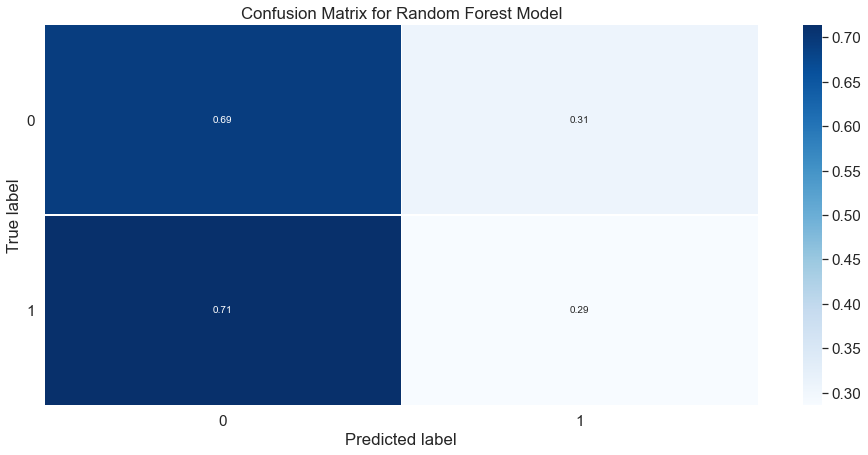

In [12]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['0', '1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# 

### Hyperparameter validation

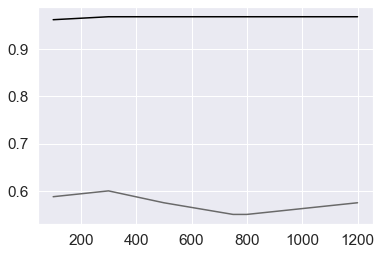

In [31]:
from sklearn.model_selection import validation_curve

num_est= [100, 300, 500, 750, 800, 1200]

train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train.ravel(), 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)
plt.plot(num_est, train_mean, label="Training score", color="black")
plt.plot(num_est, test_mean, label="Cross-validation score", color="dimgrey")

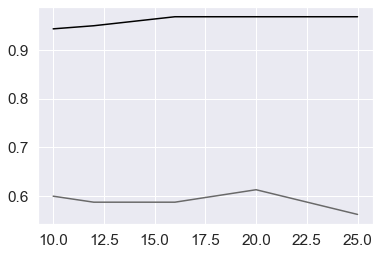

In [36]:
max_depth=[10, 12, 16, 20, 25]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train.ravel(), 
                                param_name = 'max_depth', 
                                param_range = max_depth, cv = 3)
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)
plt.plot(max_depth, train_mean, label="Training score", color="black")
plt.plot(max_depth, test_mean, label="Cross-validation score", color="dimgrey")

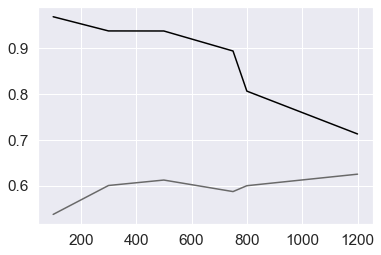

In [44]:


min_samples_split = [5, 10, 15, 20, 25, 30]

train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train.ravel(), 
                                param_name = 'min_samples_split', 
                                param_range = min_samples_split, cv = 3)
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)
plt.plot(num_est, train_mean, label="Training score", color="black")
plt.plot(num_est, test_mean, label="Cross-validation score", color="dimgrey")

C:\Users\laura\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\laura\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\laura\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\laura\anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\laura\anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\laura\anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

ValueError: x and y must have same first dimension, but have shapes (6,) and (4,)

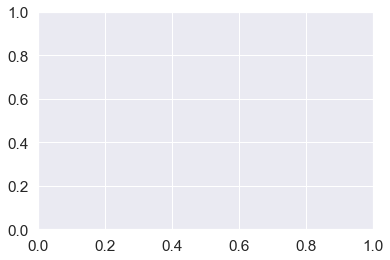

In [43]:


min_samples_leaf = [0, 1, 2, 3]

train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train.ravel(), 
                                param_name = 'min_samples_leaf', 
                                param_range = min_samples_leaf, cv = 3)
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)
plt.plot(num_est, train_mean, label="Training score", color="black")
plt.plot(num_est, test_mean, label="Cross-validation score", color="dimgrey")